In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [774]:
train = pd.read_csv("Train_aBjfeNk.csv")

In [771]:
test1 = pd.read_csv("Test_LqhgPWU.csv")

In [5]:
train.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


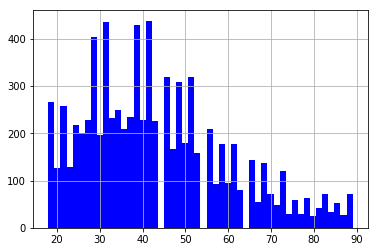

In [690]:
train['Age'].hist(bins = 50, color = 'blue')

In [728]:
train[(train['Age'] <30)].groupby('Segmentation').Var_1.count()

Segmentation
0     25
1     25
2     35
3    695
Name: Var_1, dtype: int64

In [722]:
train[(train['Age'] >60)].groupby('Segmentation').Var_1.count()

Segmentation
0    341
1    381
2    414
3    201
Name: Var_1, dtype: int64

In [730]:
train[(train['Age'] > 30) & (train['Age'] <60)].groupby('Segmentation').Var_1.count()

Segmentation
0    1254
1    1250
2    1314
3     792
Name: Var_1, dtype: int64

In [758]:
train[(train['Family_Size'] > 2) & (train['Family_Size'] < 4)].groupby('Segmentation').Var_1.count()

Segmentation
A    314
B    328
C    388
D    457
Name: Var_1, dtype: int64

In [740]:
def age_bucket(data):
    if data['Age'] < 30:
        return 0
    elif data['Age'] >= 30 and data['Age'] < 60:
        return 1
    elif data['Age'] >= 60:
        return 2

In [775]:
train['Age_bucket'] = train.apply(lambda x:age_bucket(x), axis = 1)
test['Age_bucket'] = test.apply(lambda x:age_bucket(x), axis = 1)

/opt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [762]:
def work_exp_bucket(data):
    if data['Work_Experience'] < 2:
        return 0
    elif data['Work_Experience'] >= 2 and data['Work_Experience'] < 7:
        return 1
    elif data['Work_Experience'] >= 7:
        return 2

In [776]:
train['work_exp_bucket'] = train.apply(lambda x:work_exp_bucket(x), axis = 1)
test['work_exp_bucket'] = test.apply(lambda x:work_exp_bucket(x), axis = 1)

/opt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [779]:
def family_bucket(data):
    if data['Family_Size'] <= 2:
        return 0
    elif data['Family_Size'] >= 2 and data['Family_Size'] <= 5:
        return 1
    elif data['Family_Size'] > 5:
        return 2

In [780]:
train['family_bucket'] = train.apply(lambda x:family_bucket(x), axis = 1)
test['family_bucket'] = test.apply(lambda x:family_bucket(x), axis = 1)

/opt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [782]:
train.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation,Age_bucket,work_exp_bucket,family_bucket
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D,0,0.0,1.0
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A,1,NaN,1.0
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B,2,0.0,0.0
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B,2,0.0,0.0
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A,1,NaN,2.0


In [692]:
train.groupby('Work_Experience').Profession.count()

Work_Experience
-999.0     829
 0.0      2318
 1.0      2354
 2.0       286
 3.0       255
 4.0       253
 5.0       194
 6.0       204
 7.0       196
 8.0       463
 9.0       474
 10.0       53
 11.0       50
 12.0       48
 13.0       46
 14.0       45
Name: Profession, dtype: int64

In [694]:
train.groupby('Family_Size').Profession.count()

Family_Size
-999.0     335
 1.0      1453
 2.0      2390
 3.0      1497
 4.0      1379
 5.0       612
 6.0       212
 7.0        96
 8.0        50
 9.0        44
Name: Profession, dtype: int64

In [52]:
test.shape

(2627, 10)

In [695]:
import catboost as ct

**There is leakage in data**

In [772]:
matched = pd.merge(test1,train[['ID','Segmentation']], how= 'left', on = 'ID')

In [773]:
test = matched.loc[matched['Segmentation'].isnull()]

In [83]:
print(train.shape)
print(test.shape)


(8068, 11)
(295, 11)


In [11]:
for col in train:
    print(col +' '+ str(train[col].nunique()))

ID 8068
Gender 2
Ever_Married 2
Age 67
Graduated 2
Profession 9
Work_Experience 15
Spending_Score 3
Family_Size 9
Var_1 7
Segmentation 4


In [17]:
for col in test:
    print(col +' '+ str(test[col].nunique()))

ID 2627
Gender 2
Ever_Married 2
Age 67
Graduated 2
Profession 9
Work_Experience 15
Spending_Score 3
Family_Size 9
Var_1 7


In [88]:
print(train.isnull().mean().sort_values(ascending = False))

Profession_Spending_Score      0.0
Var_1                          0.0
Gender                         0.0
Ever_Married                   0.0
Age                            0.0
Graduated                      0.0
Profession                     0.0
Work_Experience                0.0
Spending_Score                 0.0
Family_Size                    0.0
Segmentation                   0.0
Graduated_Spending_Score       0.0
Gender_Ever_Married            0.0
Gender_Graduated               0.0
Gender_Profession              0.0
Gender_Spending_Score          0.0
Ever_Married_Graduated         0.0
Ever_Married_Profession        0.0
Ever_Married_Spending_Score    0.0
Graduated_Profession           0.0
ID                             0.0
dtype: float64


In [22]:
print(train.isnull().sum().sort_values(ascending = False))

Work_Experience    829
Family_Size        335
Ever_Married       140
Profession         124
Graduated           78
Var_1               76
Segmentation         0
Spending_Score       0
Age                  0
Gender               0
ID                   0
dtype: int64


In [50]:
train.groupby('Segmentation').ID.count()

Segmentation
A    1972
B    1858
C    1970
D    2268
Name: ID, dtype: int64

In [89]:
print(test.isnull().mean().sort_values(ascending = False))

Profession_Spending_Score      0.0
Graduated_Spending_Score       0.0
Gender                         0.0
Ever_Married                   0.0
Age                            0.0
Graduated                      0.0
Profession                     0.0
Work_Experience                0.0
Spending_Score                 0.0
Family_Size                    0.0
Var_1                          0.0
Gender_Ever_Married            0.0
Gender_Graduated               0.0
Gender_Profession              0.0
Gender_Spending_Score          0.0
Ever_Married_Graduated         0.0
Ever_Married_Profession        0.0
Ever_Married_Spending_Score    0.0
Graduated_Profession           0.0
ID                             0.0
dtype: float64


In [30]:
train.groupby('Var_1').ID.count()

Var_1
Cat_1     133
Cat_2     422
Cat_3     822
Cat_4    1089
Cat_5      85
Cat_6    5238
Cat_7     203
Name: ID, dtype: int64

In [29]:
train.groupby(['Segmentation','Var_1']).ID.count()

Segmentation  Var_1
A             Cat_1      31
              Cat_2      83
              Cat_3     223
              Cat_4     333
              Cat_5      19
              Cat_6    1213
              Cat_7      51
B             Cat_1      26
              Cat_2     106
              Cat_3     186
              Cat_4     232
              Cat_5      20
              Cat_6    1232
              Cat_7      43
C             Cat_1      26
              Cat_2      99
              Cat_3     154
              Cat_4     109
              Cat_5      18
              Cat_6    1496
              Cat_7      47
D             Cat_1      50
              Cat_2     134
              Cat_3     259
              Cat_4     415
              Cat_5      28
              Cat_6    1297
              Cat_7      62
Name: ID, dtype: int64

In [33]:
train.groupby(['Profession']).ID.count()

Profession
Artist           2516
Doctor            688
Engineer          699
Entertainment     949
Executive         599
Healthcare       1332
Homemaker         246
Lawyer            623
Marketing         292
Name: ID, dtype: int64

In [35]:
train.groupby(['Gender']).ID.count()/len(train['Gender'])

Gender
Female    0.452529
Male      0.547471
Name: ID, dtype: float64

In [36]:

train.groupby(['Graduated']).ID.count()/len(train['Graduated'])

Graduated
No     0.374566
Yes    0.615766
Name: ID, dtype: float64

In [40]:

train.groupby(['Spending_Score','Graduated']).ID.count()

Spending_Score  Graduated
Average         No            503
                Yes          1450
High            No            425
                Yes           780
Low             No           2094
                Yes          2738
Name: ID, dtype: int64

In [41]:
train.groupby(['Spending_Score','Gender']).ID.count()

Spending_Score  Gender
Average         Female     831
                Male      1143
High            Female     490
                Male       726
Low             Female    2330
                Male      2548
Name: ID, dtype: int64

In [86]:
pd.pivot_table(train, index = ["Var_1"], columns = ["Profession"], values = ["ID"], aggfunc=[len])

len                                        
              ID                                        
Profession   0.0  1.0  2.0  3.0  4.0  5.0  6.0  7.0  8.0
Var_1                                                   
0.0           36   11    8   16   13   25    4   10    8
1.0          121   43   23   56   20  126   13    8   10
2.0          205   78   88  125   32  146   48   29   53
3.0          199  105  204  137   87  213   28   36   48
4.0           23    4    9   10    2   22    6    3    5
5.0         1844  416  344  577  430  741  142  530  155
6.0           63   26   18   22   10   44    1    1   11

In [653]:
test.shape

(295, 11)

In [44]:
train.dtypes == ''

ID                   int64
Gender              object
Ever_Married        object
Age                  int64
Graduated           object
Profession          object
Work_Experience    float64
Spending_Score      object
Family_Size        float64
Var_1               object
Segmentation        object
dtype: object

In [51]:
train.columns

Index([u'ID', u'Gender', u'Ever_Married', u'Age', u'Graduated', u'Profession',
       u'Work_Experience', u'Spending_Score', u'Family_Size', u'Var_1',
       u'Segmentation'],
      dtype='object')

In [787]:
train.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,...,Gender_Ever_Married,Gender_Graduated,Gender_Profession,Gender_Spending_Score,Ever_Married_Graduated,Ever_Married_Profession,Ever_Married_Spending_Score,Graduated_Profession,Graduated_Spending_Score,Profession_Spending_Score
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,...,MaleNo,MaleNo,MaleHealthcare,MaleLow,NoNo,NoHealthcare,NoLow,NoHealthcare,NoLow,HealthcareLow
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,...,FemaleYes,FemaleYes,FemaleEngineer,FemaleAverage,YesYes,YesEngineer,YesAverage,YesEngineer,YesAverage,EngineerAverage
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,...,FemaleYes,FemaleYes,FemaleEngineer,FemaleLow,YesYes,YesEngineer,YesLow,YesEngineer,YesLow,EngineerLow
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,...,MaleYes,MaleYes,MaleLawyer,MaleHigh,YesYes,YesLawyer,YesHigh,YesLawyer,YesHigh,LawyerHigh
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,...,FemaleYes,FemaleYes,FemaleEntertainment,FemaleHigh,YesYes,YesEntertainment,YesHigh,YesEntertainment,YesHigh,EntertainmentHigh


In [334]:
max(train['Graduated_Spending_Score_Profession'])

54

In [304]:
t

['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score']

In [305]:
col_concat_prof

['Gender_Ever_Married',
 'Gender_Graduated',
 'Gender_Profession',
 'Gender_Spending_Score',
 'Ever_Married_Graduated',
 'Ever_Married_Profession',
 'Ever_Married_Spending_Score',
 'Graduated_Profession',
 'Graduated_Spending_Score',
 'Profession_Spending_Score']

In [783]:
##concatenating the columns


t = [col for col in train if train[col].dtypes == np.object]
t.pop(-1)
t.pop(-1)

'Var_1'

In [784]:
##step 2

l = 1
for col in t:
    for i in range(l,len(t)):
        train[col+'_'+t[i]] = train[col] + train[t[i]]
        test[col+'_'+t[i]] = test[col] + test[t[i]]
    l = l+1

/opt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [785]:
## concatenating selected three columns
col_two = [col for col in train if train[col].dtypes == np.object]
col_two = col_two[7:]

do_not= []
for i in col_two:
    if "Profession" in i:
        do_not.append(i)

col_concat_prof = [i for i in col_two if i not in do_not]

In [786]:
col_concat_prof

['Gender_Ever_Married',
 'Gender_Graduated',
 'Gender_Spending_Score',
 'Ever_Married_Graduated',
 'Ever_Married_Spending_Score',
 'Graduated_Spending_Score']

In [788]:
##three columns

for col in col_concat_prof:
    train[col+'_Profession'] = train[col] + train['Profession']
    test[col+'_Profession']= test[col] + test['Profession']


/opt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [789]:
gender_dict = {'Female':0, 'Male':1}
Married_dict = {'No':0, 'Yes':1}
Graduated_dict = {'No':0, 'Yes':1}
Spending_Score_dict = {'Low':0, 'Average':1, 'High':2}
Var_1_dict = {'Cat_1':0, 'Cat_2':1, 'Cat_3':2, 'Cat_4':3 , 'Cat_5':4 ,'Cat_6':5 , 'Cat_7':6}
Profession_dict = {'Artist':0,'Doctor':1,'Engineer':2,'Entertainment':3,'Executive':4, 'Healthcare':5, 'Homemaker':6,'Lawyer':7,'Marketing':8}
segmentation_dict = {'A':0,'B':1,'C':2,'D':3}



In [790]:
train['Gender'] = train['Gender'].map(gender_dict)
test['Gender'] = test['Gender'].map(gender_dict)


train['Ever_Married'] = train['Ever_Married'].map(Married_dict)
test['Ever_Married'] = test['Ever_Married'].map(Married_dict)

train['Graduated'] = train['Graduated'].map(Graduated_dict)
test['Graduated'] = test['Graduated'].map(Graduated_dict)


train['Spending_Score'] = train['Spending_Score'].map(Spending_Score_dict)
test['Spending_Score'] = test['Spending_Score'].map(Spending_Score_dict)


train['Var_1'] = train['Var_1'].map(Var_1_dict)
test['Var_1'] = test['Var_1'].map(Var_1_dict)

train['Profession'] = train['Profession'].map(Profession_dict)
test['Profession'] = test['Profession'].map(Profession_dict)

train['Segmentation'] = train['Segmentation'].map(segmentation_dict)


/opt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#ind

In [794]:
train.head()


,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,...,Ever_Married_Spending_Score,Graduated_Profession,Graduated_Spending_Score,Profession_Spending_Score,Gender_Ever_Married_Profession,Gender_Graduated_Profession,Gender_Spending_Score_Profession,Ever_Married_Graduated_Profession,Ever_Married_Spending_Score_Profession,Graduated_Spending_Score_Profession
0,462809,1,0.0,22,0.0,5.0,1.0,0,4.0,3.0,...,1,6,3,18,24,24,51,6,6,24
1,462643,0,1.0,38,1.0,2.0,NaN,1,3.0,3.0,...,2,12,4,7,12,12,3,30,12,30
2,466315,0,1.0,67,1.0,2.0,1.0,0,1.0,5.0,...,4,12,6,9,12,12,21,30,30,48
3,461735,1,1.0,67,1.0,7.0,0.0,2,2.0,5.0,...,3,17,5,23,35,35,44,35,26,44
4,462669,0,1.0,40,1.0,3.0,NaN,2,6.0,5.0,...,3,13,5,11,13,13,13,31,22,40


In [792]:
#label encoding
l = 1
column_list =[]
for col in t:
    for i in range(l,len(t)):
        column_list.append(col+'_'+t[i])    
    l = l+1

for var in column_list:
    lb = LabelEncoder()
    full_var_data = pd.concat((train[var],test[var]),axis=0)
    lb.fit_transform(np.array(full_var_data))
    train[var] = lb.transform(np.array(train[var]))
    test[var] = lb.transform(np.array(test[var]))

/opt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [793]:
#label encoding for three column which we created

column_list1 =[]
for col in col_concat_prof:
        column_list1.append(col+'_Profession')    


for var in column_list1:
    lb = LabelEncoder()
    full_var_data = pd.concat((train[var],test[var]),axis=0)
    lb.fit_transform(np.array(full_var_data))
    train[var] = lb.transform(np.array(train[var]))
    test[var] = lb.transform(np.array(test[var]))

/opt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [594]:
train.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,...,Ever_Married_Spending_Score,Graduated_Profession,Graduated_Spending_Score,Profession_Spending_Score,Gender_Ever_Married_Profession,Gender_Graduated_Profession,Gender_Spending_Score_Profession,Ever_Married_Graduated_Profession,Ever_Married_Spending_Score_Profession,Graduated_Spending_Score_Profession
0,462809,1,0.0,22,0.0,5.0,1.0,0,4.0,3.0,...,1,6,3,18,24,24,51,6,6,24
1,462643,0,1.0,38,1.0,2.0,NaN,1,3.0,3.0,...,2,12,4,7,12,12,3,30,12,30
2,466315,0,1.0,67,1.0,2.0,1.0,0,1.0,5.0,...,4,12,6,9,12,12,21,30,30,48
3,461735,1,1.0,67,1.0,7.0,0.0,2,2.0,5.0,...,3,17,5,23,35,35,44,35,26,44
4,462669,0,1.0,40,1.0,3.0,NaN,2,6.0,5.0,...,3,13,5,11,13,13,13,31,22,40


In [116]:
print(train.shape)
print(test.shape)

(8068, 21)
(295, 21)


In [795]:
#### Fill nan values
train.fillna(-999, inplace=True)
test.fillna(-999, inplace=True)

In [796]:
## storing the ID's
test_ID = test['ID'].reset_index()

## dropping the ID
train.drop(['ID'], axis = 1,inplace = True)
#test.drop(['ID'], axis = 1,inplace = True)
test.drop(['ID', 'Segmentation'], axis = 1,inplace = True)

In [357]:
X_train.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Gender_Ever_Married,...,Ever_Married_Spending_Score_count,Graduated_Profession_count,Graduated_Spending_Score_count,Profession_Spending_Score_count,Gender_Ever_Married_Profession_count,Gender_Graduated_Profession_count,Gender_Spending_Score_Profession_count,Ever_Married_Graduated_Profession_count,Ever_Married_Spending_Score_Profession_count,Graduated_Spending_Score_Profession_count
7685,0,0.0,33,0.0,5.0,-999.0,0,3.0,3.0,1,...,2970,740,1862,1111,442,286,469,694,1028,720
1357,1,1.0,49,1.0,1.0,1.0,1,4.0,5.0,4,...,1725,345,1305,155,166,184,98,183,153,111
7621,1,0.0,21,0.0,5.0,2.0,0,4.0,5.0,3,...,2970,740,1862,1111,586,454,642,694,1028,720
2481,1,1.0,45,0.0,1.0,8.0,0,2.0,2.0,4,...,1374,260,1862,426,166,154,223,87,94,207
2085,0,1.0,47,1.0,0.0,7.0,1,4.0,5.0,2,...,1725,2013,1305,908,735,1003,405,1408,895,808


In [428]:
test.dtypes

Gender                           int64
Ever_Married                   float64
Age                              int64
Graduated                      float64
Profession                     float64
Work_Experience                float64
Spending_Score                   int64
Family_Size                    float64
Var_1                          float64
Gender_Ever_Married              int64
Gender_Graduated                 int64
Gender_Profession                int64
Gender_Spending_Score            int64
Ever_Married_Graduated           int64
Ever_Married_Profession          int64
Ever_Married_Spending_Score      int64
Graduated_Profession             int64
Graduated_Spending_Score         int64
Profession_Spending_Score        int64
dtype: object

In [432]:
train.shape

(8068, 20)

In [797]:
#validation set
X_train, X_test, y_train, y_test = train_test_split(train.drop(['Segmentation'], axis = 1), 
                                                    train['Segmentation'], test_size = 0.2, 
                                                    random_state = 2)

In [488]:
column = list(test.columns)[6:]
column.append('Profession')


In [572]:
list(test.columns)[18:]

['Graduated_Profession',
 'Graduated_Spending_Score',
 'Profession_Spending_Score',
 'Gender_Ever_Married_Profession',
 'Gender_Graduated_Profession',
 'Gender_Spending_Score_Profession',
 'Ever_Married_Graduated_Profession',
 'Ever_Married_Spending_Score_Profession',
 'Graduated_Spending_Score_Profession']

In [809]:
list(test.columns)

['Gender',
 'Ever_Married',
 'Age',
 'Graduated',
 'Profession',
 'Work_Experience',
 'Spending_Score',
 'Family_Size',
 'Var_1',
 'Age_bucket',
 'work_exp_bucket',
 'family_bucket',
 'Gender_Ever_Married',
 'Gender_Graduated',
 'Gender_Profession',
 'Gender_Spending_Score',
 'Ever_Married_Graduated',
 'Ever_Married_Profession',
 'Ever_Married_Spending_Score',
 'Graduated_Profession',
 'Graduated_Spending_Score',
 'Profession_Spending_Score',
 'Gender_Ever_Married_Profession',
 'Gender_Graduated_Profession',
 'Gender_Spending_Score_Profession',
 'Ever_Married_Graduated_Profession',
 'Ever_Married_Spending_Score_Profession',
 'Graduated_Spending_Score_Profession']

In [810]:
list(test.columns)[12:]

['Gender_Ever_Married',
 'Gender_Graduated',
 'Gender_Profession',
 'Gender_Spending_Score',
 'Ever_Married_Graduated',
 'Ever_Married_Profession',
 'Ever_Married_Spending_Score',
 'Graduated_Profession',
 'Graduated_Spending_Score',
 'Profession_Spending_Score',
 'Gender_Ever_Married_Profession',
 'Gender_Graduated_Profession',
 'Gender_Spending_Score_Profession',
 'Ever_Married_Graduated_Profession',
 'Ever_Married_Spending_Score_Profession',
 'Graduated_Spending_Score_Profession']

In [811]:
###Adding Frequency encoding as a feature
## taking only concatenated columns


def frequency_encoding(train_set, test_set, validation_set, col) :
    grouped_df = train_set.groupby(col)
    count_dict = {}
    for name, group in grouped_df:
        count_dict[name] = group.shape[0]
    train_set[col+'_count'] = train_set[col].map(count_dict)
    test_set[col+'_count'] = test_set[col].map(count_dict)
    validation_set[col+'_count'] = validation_set[col].map(count_dict)

    
#column = ['Graduated','Profession','Spending_Score', 'Var_1', 'Family_Size']
#column = list(test.columns)[6:]
#column= list(test.columns)[18:]
column= list(test.columns)[12:]
column.append('Profession')
column.append('Family_Size')
#column.append('Var_1')

for i in column:
    frequency_encoding(X_train, test, X_test, i)




/opt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [812]:
print(X_train.shape)
print(X_test.shape)
print(test.shape)

(6454, 46)
(1614, 46)
(295, 46)


**XGboost**

In [813]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [814]:
dtest1 = xgb.DMatrix(test)

In [108]:
params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    'eval_metric': "auc",
    # Other parameters
    'objective':'multi:softprob',
    'num_class': 4
}

In [848]:
param = {
    'max_depth': 3,  # the maximum depth of each tree
    'min_child_weight': 1,
    'eta': 0.1,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'colsample_bytree': 0.8,
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 4}  # the number of classes that exist in this datset
num_round = 850  # the number of training iterations

In [849]:
bst = xgb.train(param, dtrain, num_round)

In [845]:
preds = bst.predict(dtrain)
preds1 = bst.predict(dtest)

In [850]:
preds = bst.predict(dtest1)

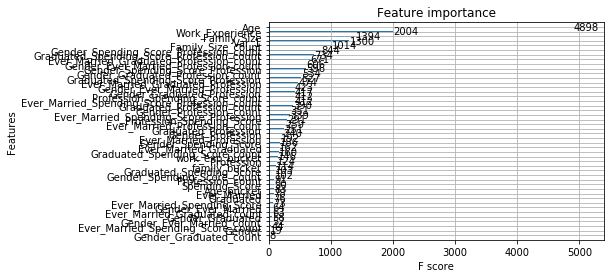

In [831]:
#importance plot

xgb.plot_importance(bst)

In [846]:
best_preds = np.asarray([np.argmax(line) for line in preds])
best_preds1 = np.asarray([np.argmax(line) for line in preds1])

In [847]:
print(accuracy_score(y_train, best_preds))
print(accuracy_score(y_test, best_preds1))     

0.7045243259993802
0.5390334572490706


In [641]:
print(accuracy_score(y_train, best_preds))
print(accuracy_score(y_test, best_preds1)) 

0.7015804152463588
0.540272614622057


In [927]:
best_preds = np.asarray([np.argmax(line) for line in preds])

In [928]:
best_preds = pd.DataFrame(best_preds)
best_preds.columns = ['Segmentation1']

In [550]:
best_preds

,Segmentation1
0,0
1,1
2,0
3,2
4,2
5,0
6,2
7,1
8,2
9,2


In [929]:
###merging the results

results = pd.concat([test_ID, best_preds], axis =1)
results.set_index('index', inplace=True)

##convert back 
segmentation_dict1 = {0:'A',1:'B',2:'C',3: 'D'}
results['Segmentation1'] = results['Segmentation1'].map(segmentation_dict1)

results =pd.concat([matched,results['Segmentation1']], axis =1)
results['Segmentation'].fillna(results['Segmentation1'], inplace =True)

In [930]:
results[['ID','Segmentation']].to_csv('prediction9.csv', index = False)

In [25]:
accuracy_score(y_test, best_preds)

0.5384138785625775

In [213]:
##convert back 
segmentation_dict1 = {0:'A',1:'B',2:'C',3: 'D'}
results['Segmentation'] = results['Segmentation'].map(segmentation_dict1)

In [32]:
##convert back 
segmentation_dict1 = {0:'A',1:'B',2:'C',3: 'D'}
best_preds['Segmentation'] = best_preds['Segmentation'].map(segmentation_dict1)

In [217]:
results.to_csv('prediction.csv', index = False)

In [33]:
best_preds.to_csv('prediction1.csv', index = False)

**Catboost

In [696]:
from catboost import Pool, CatBoostClassifier

In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [697]:
train_pool = Pool(data=X_train, label=y_train)
test_pool = Pool(data=X_test, label=y_test) 

In [707]:
test1_pool = Pool(data=test)

In [711]:
model = CatBoostClassifier(
    iterations=100,
    learning_rate=0.05,
    random_strength=0.1,
    depth=8,
    loss_function='MultiClass',
    eval_metric='Accuracy',
    leaf_estimation_method='Newton'
)

In [712]:
bst1 =model.fit(train_pool,plot=True,eval_set=test_pool)

MetricVisualizer(layout=Layout(align_self=u'stretch', height=u'500px'))

0:	learn: 0.5345522	test: 0.4987608	best: 0.4987608 (0)	total: 28.6ms	remaining: 2.83s
1:	learn: 0.5453982	test: 0.5037175	best: 0.5037175 (1)	total: 42.3ms	remaining: 2.07s
2:	learn: 0.5447784	test: 0.5049566	best: 0.5049566 (2)	total: 75.8ms	remaining: 2.45s
3:	learn: 0.5540750	test: 0.5099133	best: 0.5099133 (3)	total: 93.9ms	remaining: 2.25s
4:	learn: 0.5570189	test: 0.5167286	best: 0.5167286 (4)	total: 109ms	remaining: 2.08s
5:	learn: 0.5517509	test: 0.5198265	best: 0.5198265 (5)	total: 123ms	remaining: 1.93s
6:	learn: 0.5570189	test: 0.5167286	best: 0.5198265 (5)	total: 137ms	remaining: 1.82s
7:	learn: 0.5570189	test: 0.5173482	best: 0.5198265 (5)	total: 151ms	remaining: 1.74s
8:	learn: 0.5581035	test: 0.5223048	best: 0.5223048 (8)	total: 165ms	remaining: 1.67s
9:	learn: 0.5562442	test: 0.5210657	best: 0.5223048 (8)	total: 179ms	remaining: 1.61s
10:	learn: 0.5596529	test: 0.5247831	best: 0.5247831 (10)	total: 192ms	remaining: 1.55s
11:	learn: 0.5598079	test: 0.5229244	best: 0.524

97:	learn: 0.6189960	test: 0.5285006	best: 0.5340768 (22)	total: 1.41s	remaining: 28.8ms
98:	learn: 0.6203905	test: 0.5266419	best: 0.5340768 (22)	total: 1.42s	remaining: 14.4ms
99:	learn: 0.6196157	test: 0.5266419	best: 0.5340768 (22)	total: 1.44s	remaining: 0us

bestTest = 0.5340768278
bestIteration = 22

Shrink model to first 23 iterations.


In [708]:
preds = bst1.predict(train_pool)
preds1 = bst1.predict(test_pool)

In [709]:
best_preds = np.asarray([np.argmax(line) for line in preds])
best_preds1 = np.asarray([np.argmax(line) for line in preds1])

In [710]:
print(accuracy_score(y_train, best_preds))
print(accuracy_score(y_test, best_preds1)) 

0.24248528044623488
0.25216852540272616


In [ ]:
preds = bst.predict()
best_preds = np.asarray([np.argmax(line) for line in preds])

**Light GBM

In [855]:
import lightgbm as lgb

/opt/anaconda2/lib/python2.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [947]:
params = {'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class':4,
    'learning_rate': 0.05,
    'feature_fraction': 0.5,
    'max_depth': 4}

In [857]:
d_train=lgb.Dataset(X_train, label=y_train)

In [858]:
d_test=lgb.Dataset(X_test, label=y_test)

In [948]:
clf=lgb.train(params,d_train,100)

In [949]:
preds = clf.predict(X_train)
preds1 = clf.predict(X_test)

In [950]:
best_preds = np.asarray([np.argmax(line) for line in preds])
best_preds1 = np.asarray([np.argmax(line) for line in preds1])

In [951]:
print(accuracy_score(y_train, best_preds))
print(accuracy_score(y_test, best_preds1)) 

0.5780911062906724
0.5359355638166047


In [926]:
preds = clf.predict(test)

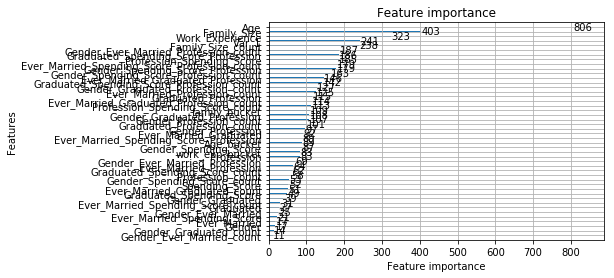

In [953]:
lgb.plot_importance(clf)

In [918]:
lgb_cv = lgb.cv(params, d_train, num_boost_round=10000, nfold=3, shuffle=True, stratified=True, verbose_eval=20, early_stopping_rounds=100)

nround = lgb_cv['accuracy-mean'].index(np.min(lgb_cv['accuracy-mean']))
print(nround)

model = lgb.train(params, d_train, num_boost_round=nround)

LightGBMError: Multiclass objective and metrics don't match

In [912]:
preds = model.predict(X_train)
preds1 = model.predict(X_test)

In [ ]:
preds = model.predict(test)
print(preds)             